In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc ,f1_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV



from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.inspection import PartialDependenceDisplay


In [2]:
#reading data from train.csv in dataset folder 
def read_data(file_path):    
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

In [3]:
# Read the training data
train_data = read_data('./dataset/train.csv')
if train_data is not None:
    print("Data loaded successfully!")

Data loaded successfully!


In [5]:
def preprocess_data():
    train_data = read_data('./dataset/train.csv')
    if train_data is not None:
        print("Data loaded successfully!")
    # Handle categorical variables
    categorical_columns = ['Gender', 'City', 'Working Professional or Student', 
                          'Profession', 'Sleep Duration', 'Dietary Habits', 
                          'Degree', 'Have you ever had suicidal thoughts ?',
                          'Family History of Mental Illness']
    label_encoders = {}
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        train_data[column] = label_encoders[column].fit_transform(train_data[column].fillna('Missing'))
    numerical_columns = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
                    'Financial Stress']
    for column in numerical_columns:
        train_data[column] = train_data[column].fillna(train_data[column].median())
    X = train_data.drop(['id', 'Name', 'Depression'], axis=1)
    y = train_data['Depression']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


In [7]:
def select_specific_features_data(features):
    # Get the preprocessed data
    X_train, X_test, y_train, y_test = preprocess_data()
    
    # Verify all requested features exist in the data
    available_features = set(X_train.columns)
    requested_features = set(features)
    
    missing_features = requested_features - available_features
    if missing_features:
        raise ValueError(f"The following features are not available: {missing_features}")
    
    # Select only the specified features
    X_train = X_train[list(features)]
    X_test = X_test[list(features)]
    
    return X_train, X_test, y_train, y_test

# SVM

In [8]:

count = 10000
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_reduced = X_train_scaled[:count]
y_train_reduced = y_train[:count]
X_test_reduced = X_test_scaled[:count]
y_test_reduced = y_test[:count ]


Data loaded successfully!


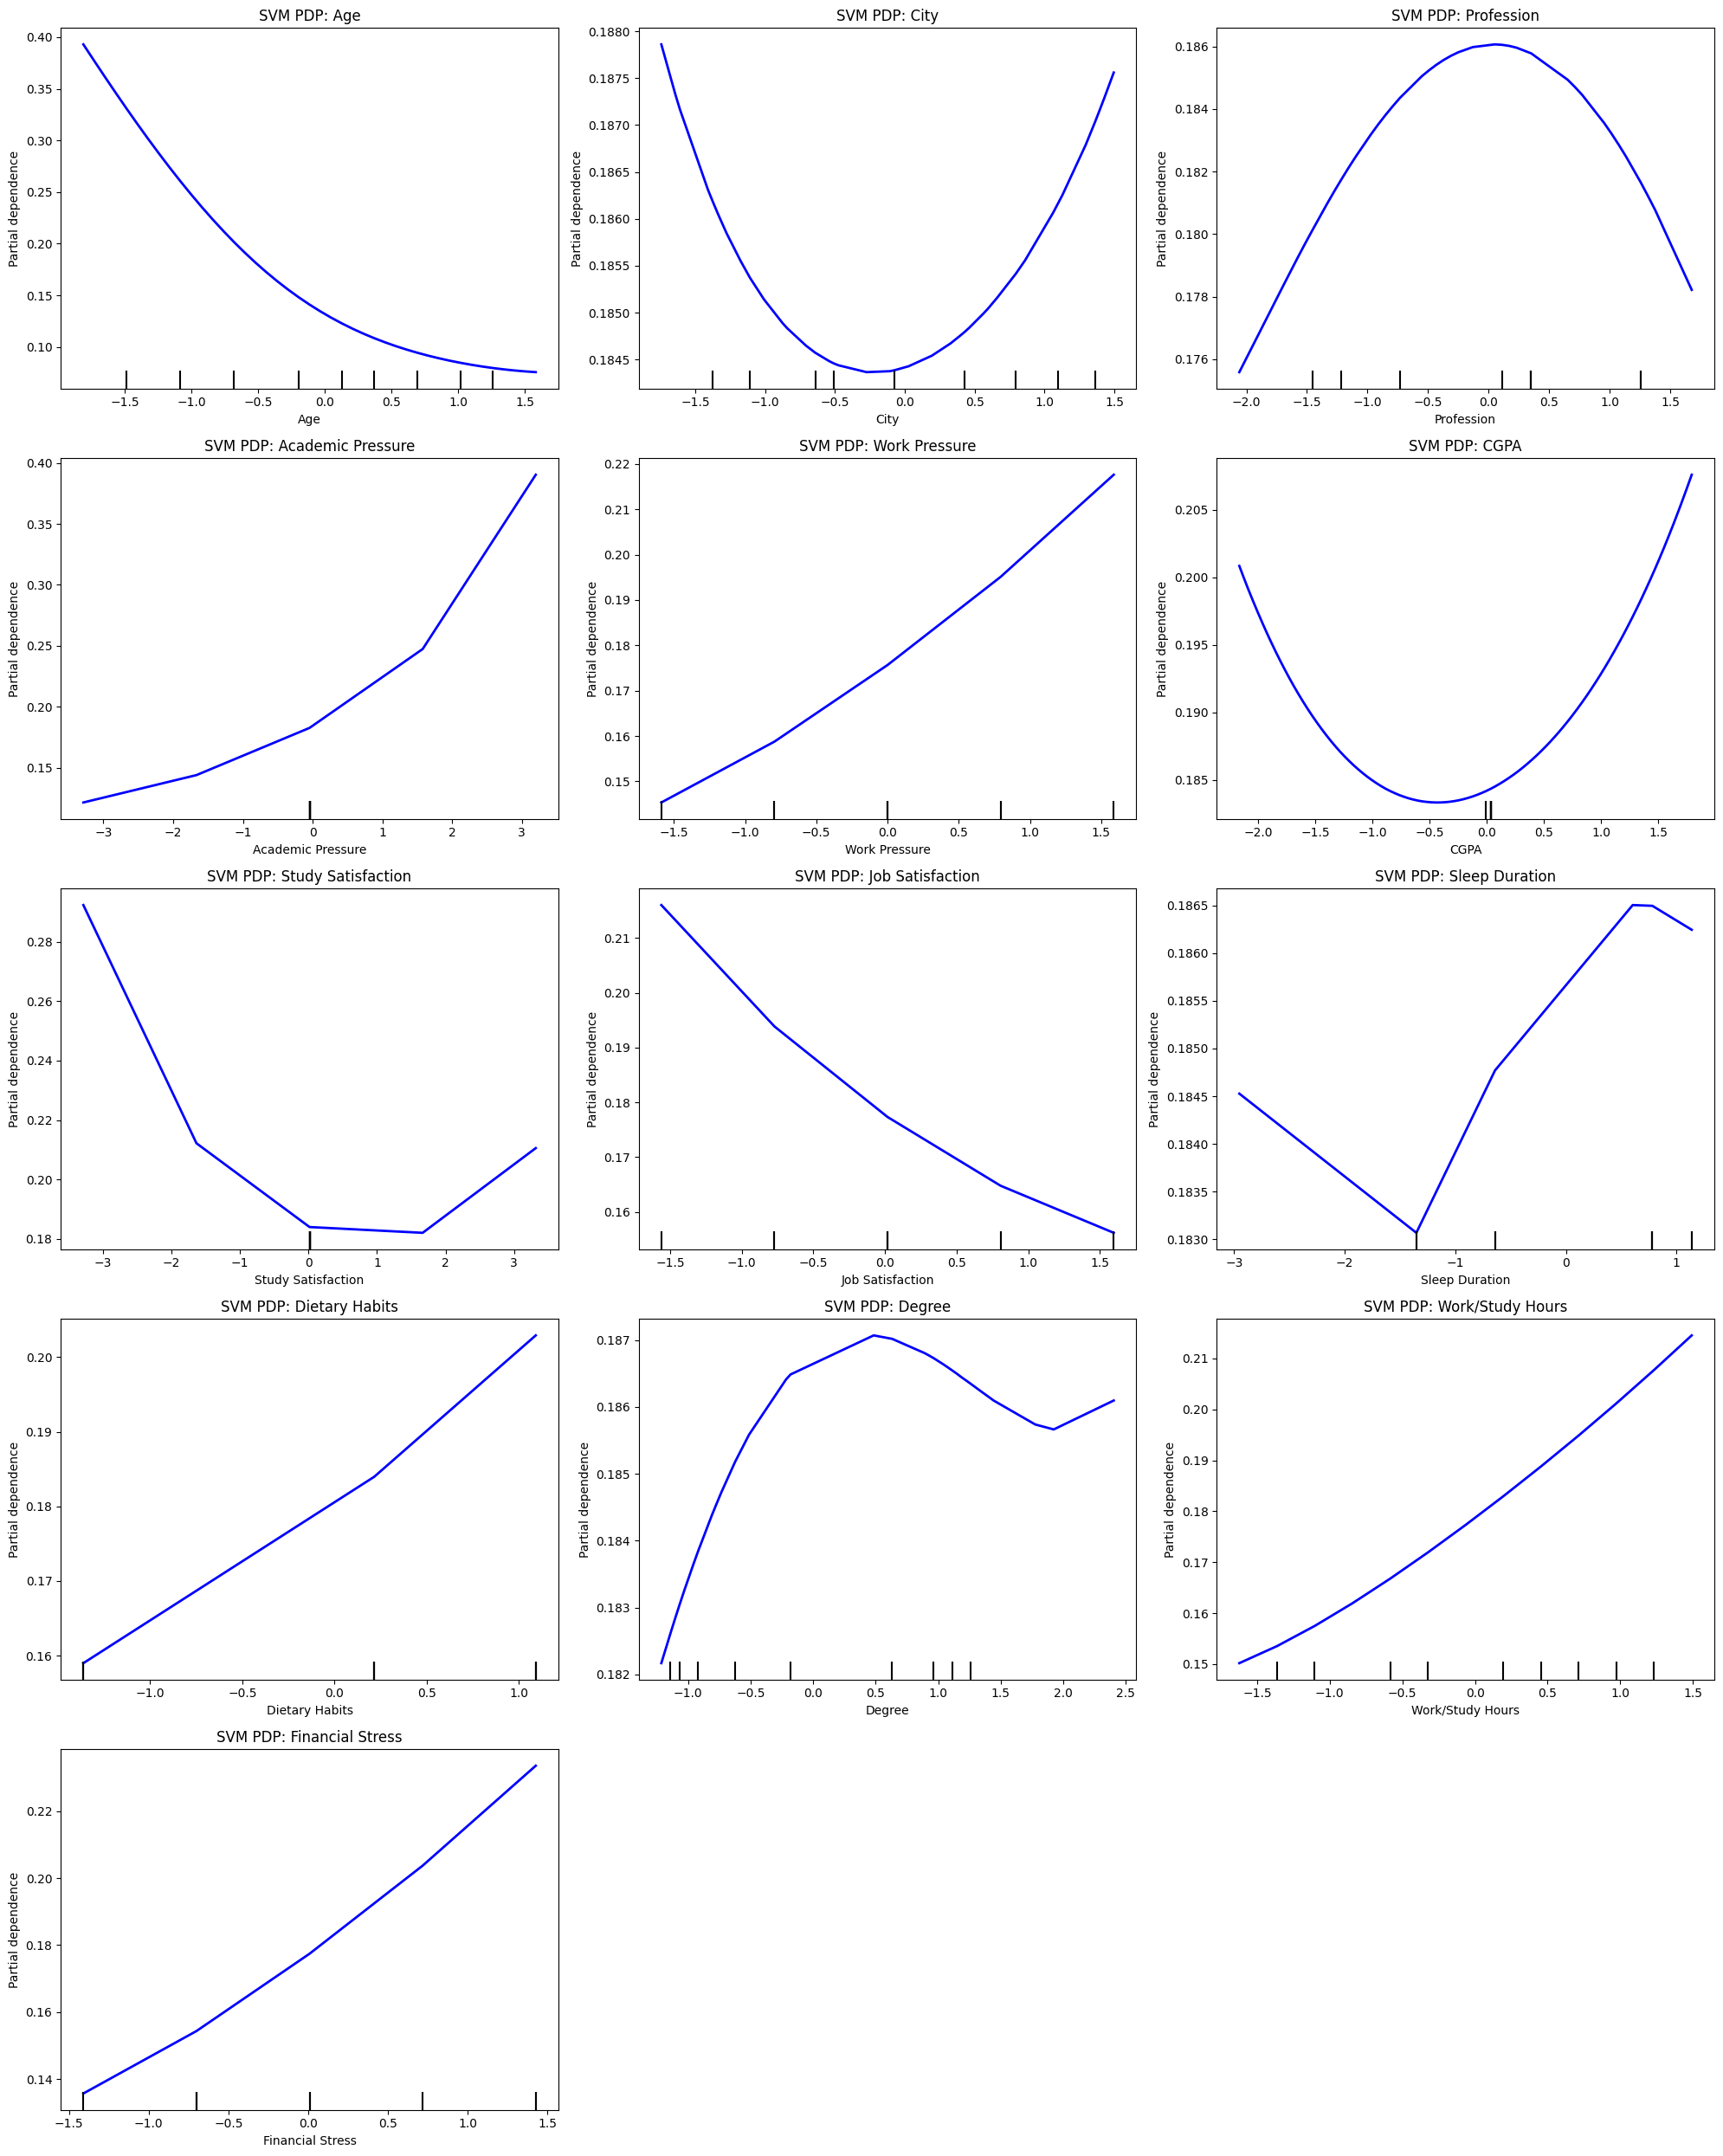

In [14]:
from sklearn.svm import SVC
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Initialize SVM model (adjust parameters as needed)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_reduced, y_train_reduced)

# Your selected features
features = ['Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 
            'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 
            'Dietary Habits', 'Degree', 'Work/Study Hours', 'Financial Stress']

# Create subplot grid
n_cols = 3  # 3 plots per row
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Generate PDP for each feature
for i, feature in enumerate(features):
    try:
        PartialDependenceDisplay.from_estimator(
            svm_model,
            X_train_reduced ,
            features=[feature],
            feature_names=X_train.columns.tolist(),
            ax=axes[i],
            line_kw={'color': 'blue', 'linewidth': 2}
        )
        axes[i].set_title(f"SVM PDP: {feature}", fontsize=12)
        axes[i].grid(True, alpha=0.3)
    except Exception as e:
        print(f"Could not create PDP for {feature}: {str(e)}")
        axes[i].set_visible(False)

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Define the hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],              # Regularization parameter
    'gamma': [0.1, 1,10],   # Kernel coefficient
    'kernel': ['linear', 'rbf'],          # Kernel type
}

# Set up GridSearchCV for SVM
grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),  # probability=True for later analysis
    param_grid=param_grid,
    cv=5,                          # 5-fold cross-validation
    scoring=make_scorer(f1_score),  # Use F1 for imbalanced data
    n_jobs=-1,                     # Use all CPU cores
    verbose=2                      # Print progress
)

# Fit the grid search
grid_search.fit(X_train_reduced, y_train_reduced)

# --- Results Analysis ---
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# --- Best Model Evaluation ---
best_svm = grid_search.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best F1 Score: 0.8227069005201078
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  37.6s
[CV] END .....................C=0.1, gamma=10, kernel=linear; total time=   4.7s
[CV] END .....................C=0.1, gamma=10, kernel=linear; total time=   5.4s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; total time=  41.5s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   7.5s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   7.1s
[CV] END ........................

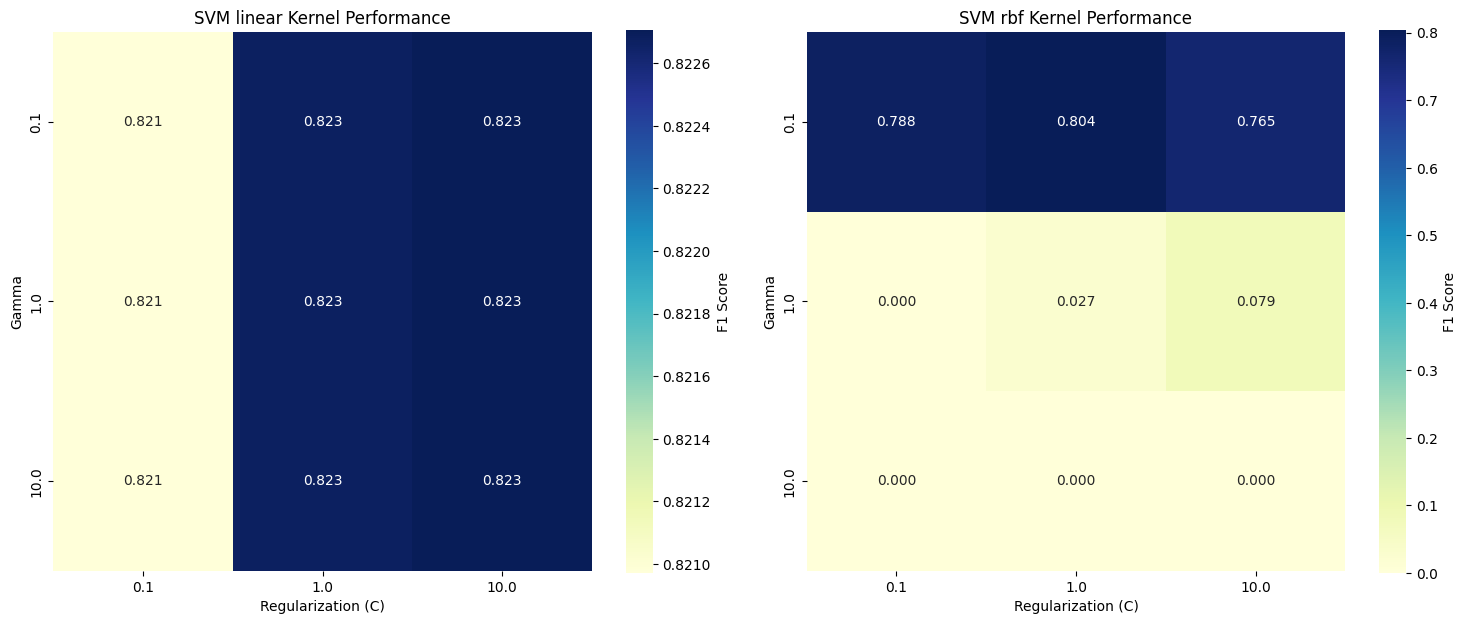

In [17]:
# Create subplots for each kernel type
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, kernel in enumerate(['linear', 'rbf']):
    kernel_results = results[results['param_kernel'] == kernel]
    heatmap_data = kernel_results.pivot(index='param_gamma', 
                                      columns='param_C', 
                                      values='mean_test_score')
    
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt=".3f", 
                cmap="YlGnBu",
                ax=axes[i],
                cbar_kws={'label': 'F1 Score'},
                square=True)
    
    axes[i].set_title(f"SVM {kernel} Kernel Performance")
    axes[i].set_xlabel("Regularization (C)")
    axes[i].set_ylabel("Gamma")

plt.tight_layout()
plt.show()


SVM Bias-Variance Analysis (n=10000)
Accuracy: 0.9344
Bias: 0.0656
Variance: 0.0137


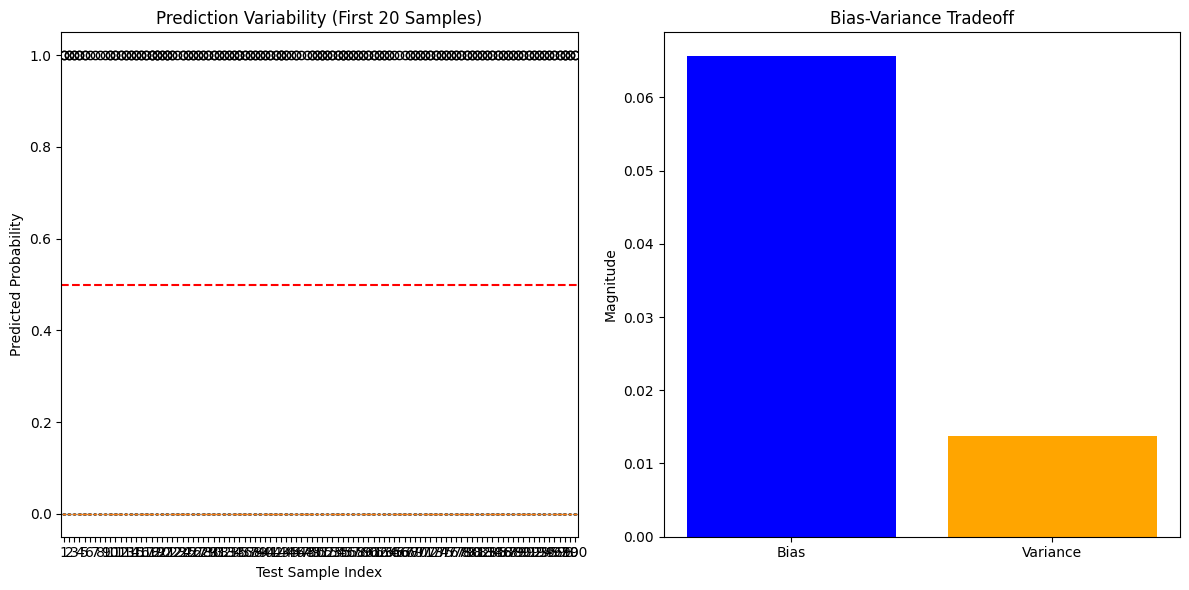

In [21]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_models = 100  # Number of bootstrap models
test_size = 0.2  # Size of bootstrap samples

# Storage for predictions (using 0/1 for classification)
predictions = np.zeros((n_models, len(X_test_reduced)))

# SVM parameters (adjust as needed)
svm_params = {
    'kernel': 'rbf',
    'C': 1.0,
    'gamma': 'scale',
    'probability': True
}

# Convert y_train_reduced to numpy array if it's a pandas Series
if hasattr(y_train_reduced, 'iloc'):
    y_train_np = y_train_reduced.values
else:
    y_train_np = y_train_reduced

# Train multiple models on bootstrap samples
for i in range(n_models):
    # Create bootstrap sample (with replacement)
    idx = np.random.choice(len(X_train_reduced), 
                         size=int(len(X_train_reduced)*(1-test_size)), 
                         replace=True)
    X_boot = X_train_reduced[idx]
    y_boot = y_train_np[idx]  # Use the numpy array version
    
    # Train SVM and predict probabilities
    model = SVC(**svm_params)
    model.fit(X_boot, y_boot)
    predictions[i] = model.predict(X_test_reduced)

# Calculate components (for classification)
mean_predictions = np.mean(predictions, axis=0)
y_pred = (mean_predictions > 0.5).astype(int)  # Convert probabilities to class labels

# Convert y_test_reduced to numpy array if needed
if hasattr(y_test_reduced, 'iloc'):
    y_test_np = y_test_reduced.values
else:
    y_test_np = y_test_reduced

# Bias: Average difference between predicted and true class
bias = np.mean(y_pred != y_test_np)

# Variance: Measure of prediction variability
variance = np.mean(np.var(predictions, axis=0))

# Accuracy metrics
accuracy = np.mean(y_pred == y_test_np)
print(f"\nSVM Bias-Variance Analysis (n={count})")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")

# Visualization
plt.figure(figsize=(12, 6))

# Plot prediction distribution for first 20 test samples
plt.subplot(1, 2, 1)
plt.boxplot(predictions[:, :20].T)
plt.axhline(0.5, color='r', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Prediction Variability (First 20 Samples)')

# Plot bias-variance tradeoff
plt.subplot(1, 2, 2)
plt.bar(['Bias', 'Variance'], [bias, variance], color=['blue', 'orange'])
plt.ylabel('Magnitude')
plt.title('Bias-Variance Tradeoff')
plt.tight_layout()
plt.show()

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time


# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of kernels to try
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Dictionary to store results
results = {}

for kernel in kernels:
    # Create and train model
    print(f"\nTraining SVM with {kernel} kernel...")
    start_time = time.time()
    
    svm_model = SVC(
        kernel=kernel,
        random_state=42,
        probability=True  # Enable probability estimates
    )
    
    # Fit model
    svm_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test_scaled)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results[kernel] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'training_time': training_time,
        'report': classification_report(y_test, y_pred)
    }
    
    print(f"\nResults for {kernel} kernel:")
    print(f"Accuracy: {results[kernel]['accuracy']:.4f}")
    print(f"Training time: {results[kernel]['training_time']:.2f} seconds")
    print("\nClassification Report:")
    print(results[kernel]['report'])

Data loaded successfully!

Training SVM with linear kernel...

Results for linear kernel:
Accuracy: 0.9362
Training time: 722.01 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.84      0.81      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140


Training SVM with rbf kernel...

Results for rbf kernel:
Accuracy: 0.9360
Training time: 693.46 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22986
           1       0.85      0.79      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.94      0.94     28140


Training SVM with poly kernel...

Results for poly kern


SVM Bias-Variance Decomposition (kernel=rbf)
MSE: 0.28545668
Bias²: 0.25542993
Variance: 0.03002675
Noise: 1.51089558
Bias² + Variance: 0.28545668
Estimated Eout (MSE): 0.28545668


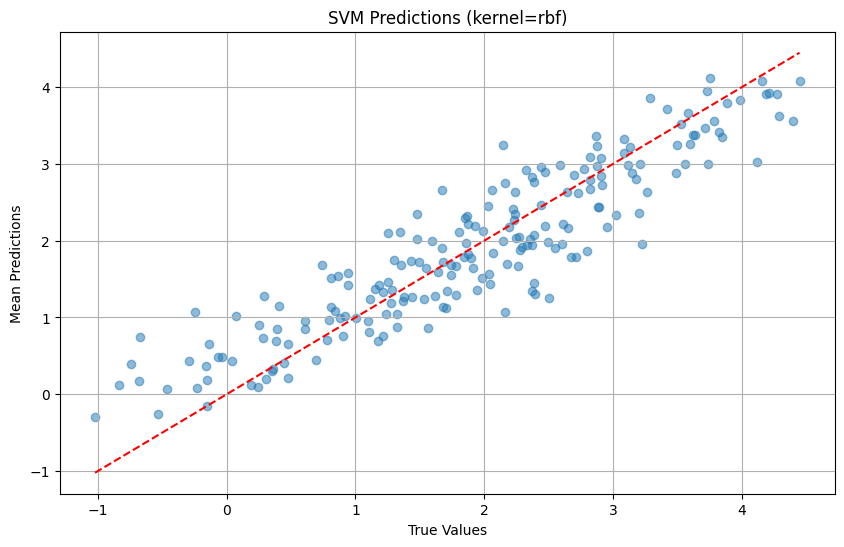

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR  # Using SVR for regression
from sklearn.metrics import mean_squared_error

# Generate synthetic data (same as before)
np.random.seed(42)
X = np.random.rand(1000, 5)  # 1000 samples, 5 features
y = 2*X[:,0] + 3*X[:,1] - X[:,2] + np.random.normal(0, 0.5, 1000)

# Hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Parameters
n_models = 100  # Number of bootstrap models
test_size = 0.2  # Size of bootstrap samples

# Storage
predictions = np.zeros((n_models, len(X_test)))

# SVM-specific parameters
svm_params = {
    'kernel': 'rbf',  # Can change to 'linear' or others
    'C': 1.0,         # Regularization parameter
    'gamma': 'scale'  # Kernel coefficient
}

# Train multiple models on bootstrap samples
for i in range(n_models):
    # Create bootstrap sample
    idx = np.random.choice(len(X_train), size=int(len(X_train)*(1-test_size)), replace=True)
    X_boot = X_train[idx]
    y_boot = y_train[idx]
    
    # Train SVM and predict
    model = SVR(**svm_params)
    model.fit(X_boot, y_boot)
    predictions[i] = model.predict(X_test)

# Calculate components
mean_predictions = np.mean(predictions, axis=0)
bias_squared = np.mean((mean_predictions - y_test)**2)
variance = np.mean(np.var(predictions, axis=0))
noise = np.var(y_test)  # Irreducible error
mse = np.mean((predictions - y_test)**2)

print(f"\nSVM Bias-Variance Decomposition (kernel={svm_params['kernel']})")
print("="*50)
print(f"MSE: {mse:.8f}")
print(f"Bias²: {bias_squared:.8f}")
print(f"Variance: {variance:.8f}")
print(f"Noise: {noise:.8f}")
print(f"Bias² + Variance: {bias_squared + variance:.8f}")
print(f"Estimated Eout (MSE): {mse:.8f}")

# Visualization of predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, mean_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Values")
plt.ylabel("Mean Predictions")
plt.title(f"SVM Predictions (kernel={svm_params['kernel']})")
plt.grid(True)
plt.show()

# Random Forest

Data loaded successfully!

Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.82      0.84      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.89      0.90      0.89     28140
weighted avg       0.94      0.94      0.94     28140



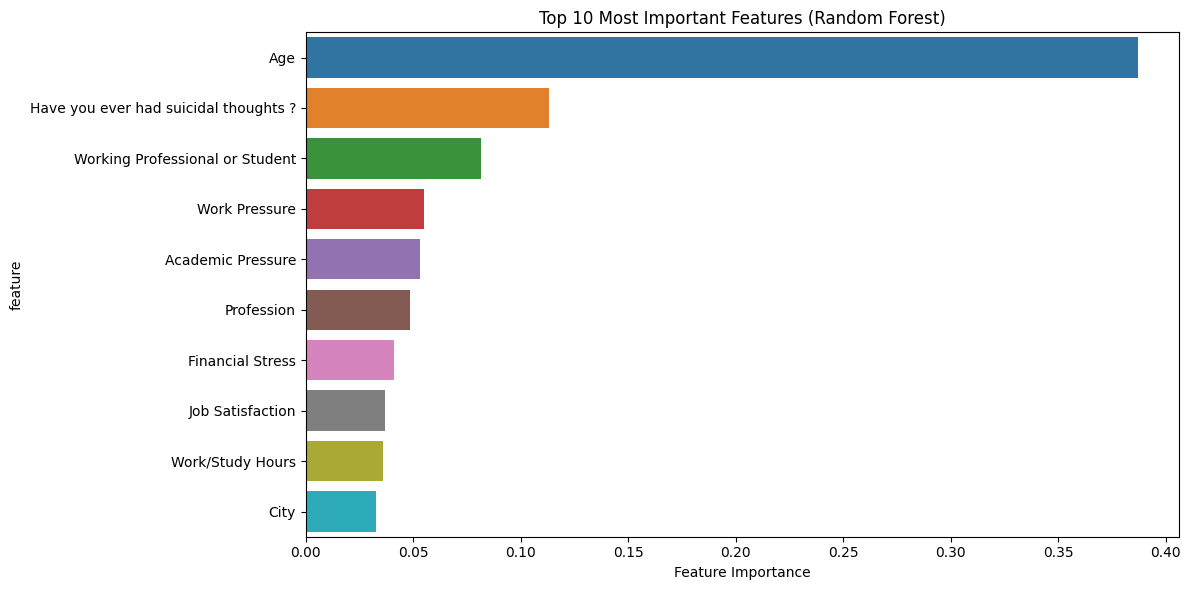


Top 10 Most Important Features:
                                  feature  importance
1                                     Age    0.387097
13  Have you ever had suicidal thoughts ?    0.113149
3         Working Professional or Student    0.081522
6                           Work Pressure    0.054889
5                       Academic Pressure    0.053162
4                              Profession    0.048749
15                       Financial Stress    0.040955
9                        Job Satisfaction    0.036874
14                       Work/Study Hours    0.035882
2                                    City    0.032504


In [22]:
# Import necessary libraries

#Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


X_train, X_test, y_train, y_test = preprocess_data()

# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,    # Number of trees in the forest
    max_depth=20,        # Maximum depth of each tree
    min_samples_split=5, # Minimum samples required to split a node
    min_samples_leaf=1,  # Minimum samples required at each leaf node
    random_state=42,
    class_weight='balanced' # Handle class imbalance
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Print model performance
print("\nRandom Forest Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print detailed feature importance
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string())




Data loaded successfully!

Random Forest Bias-Variance Analysis (n=100)
Accuracy: 0.9373
Bias: 0.0627
Variance: 0.0081


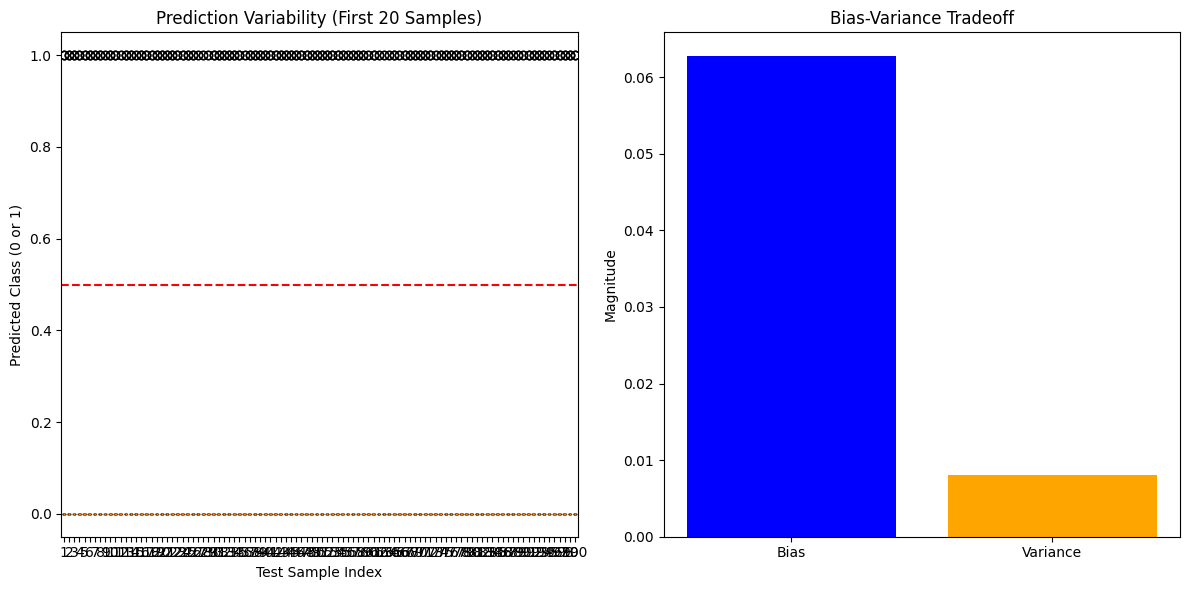

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data()

from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

np.random.seed(42)

# Parameters
n_models = 100  # Number of bootstrap models
test_size = 0.2  # Bootstrap sample fraction
predictions = np.zeros((n_models, len(X_test)))

# Convert y_train to numpy array if needed
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Random Forest parameters
rf_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'random_state': 42,
    'class_weight': 'balanced'
}

# Train models on bootstrap samples
for i in range(n_models):
    idx = np.random.choice(len(X_train), size=int(len(X_train)*(1 - test_size)), replace=True)
    X_boot = X_train.iloc[idx] if hasattr(X_train, 'iloc') else X_train[idx]
    y_boot = y_train_np[idx]

    model = RandomForestClassifier(**rf_params)
    model.fit(X_boot, y_boot)
    predictions[i] = model.predict(X_test)

# Aggregate predictions
mean_predictions = np.mean(predictions, axis=0)
y_pred_rf = (mean_predictions > 0.5).astype(int)

# Bias and variance
bias_rf = np.mean(y_pred_rf != y_test_np)
variance_rf = np.mean(np.var(predictions, axis=0))
accuracy_rf = np.mean(y_pred_rf == y_test_np)

print(f"\nRandom Forest Bias-Variance Analysis (n=200)")
print("="*50)
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Bias: {bias_rf:.4f}")
print(f"Variance: {variance_rf:.4f}")

# Visualization
plt.figure(figsize=(12, 6))

# Boxplot for prediction variability (first 20 test samples)
plt.subplot(1, 2, 1)
plt.boxplot(predictions[:, :20].T)
plt.axhline(0.5, color='r', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted Class (0 or 1)')
plt.title('Prediction Variability (First 20 Samples)')

# Bias-variance bar chart
plt.subplot(1, 2, 2)
plt.bar(['Bias', 'Variance'], [bias_rf, variance_rf], color=['blue', 'orange'])
plt.ylabel('Magnitude')
plt.title('Bias-Variance Tradeoff')
plt.tight_layout()
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Create Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
# Perform grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
# Fit grid search
grid_search.fit(X_train, y_train)
# Get best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


# Logistic Regression

Data loaded successfully!

Logistic Regression Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.80      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140



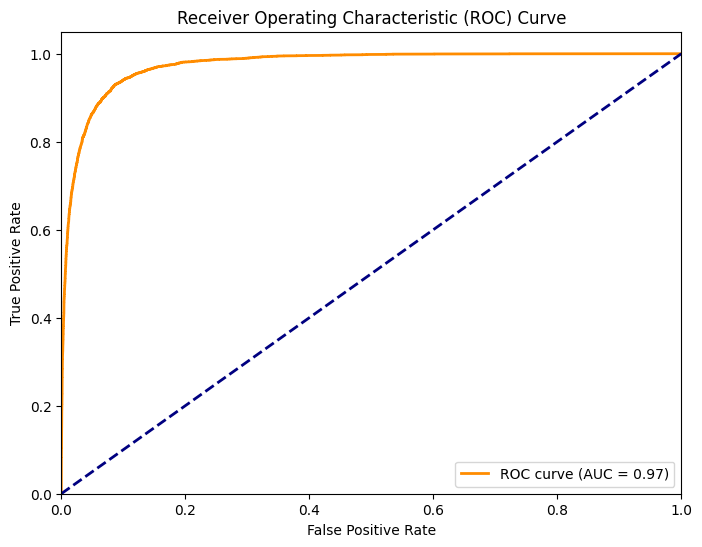

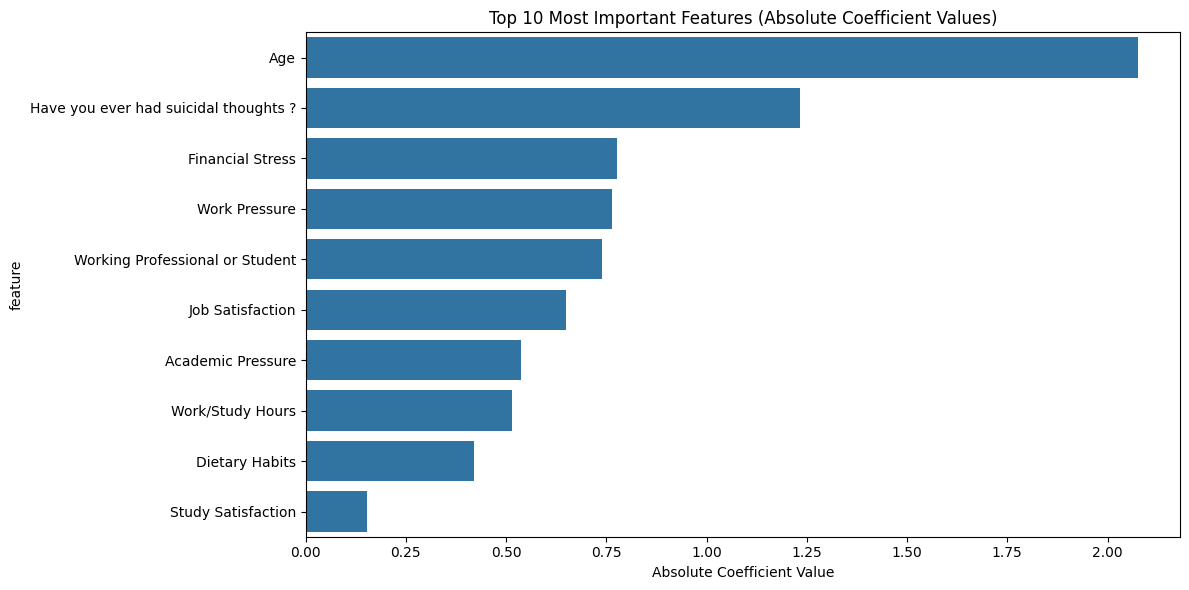


Top 10 Features by Odds Ratio:
                                  feature  odds_ratio  coefficient
13  Have you ever had suicidal thoughts ?    3.429659     1.232461
15                       Financial Stress    2.171382     0.775364
6                           Work Pressure    2.149301     0.765143
5                       Academic Pressure    1.711352     0.537283
14                       Work/Study Hours    1.675047     0.515841
11                         Dietary Habits    1.521259     0.419538
16       Family History of Mental Illness    1.117508     0.111101
7                                    CGPA    1.044964     0.043983
12                                 Degree    1.026048     0.025714
10                         Sleep Duration    1.023994     0.023710


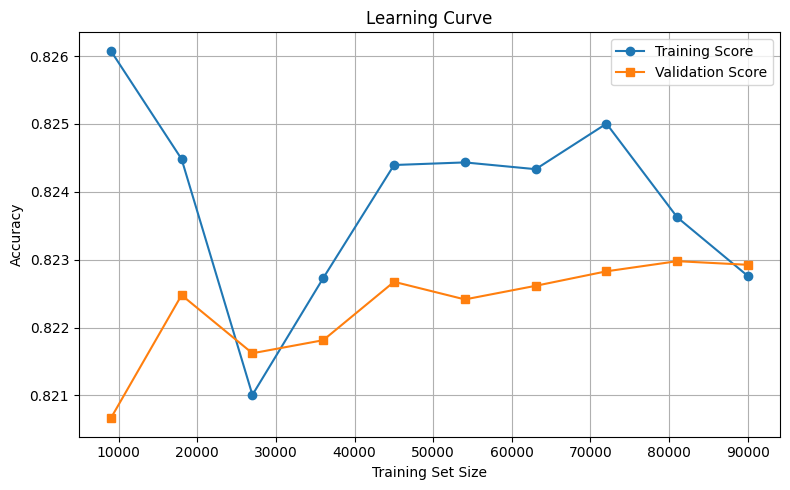

In [ ]:
#Best Parameters Found:
# {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Logistic Regression model
lr_model = LogisticRegression(
    max_iter=1000,      
    random_state=42,
    class_weight=None ,
    penalty='l1',
    solver='saga',
    C=0.1
)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Print model performance
print("\nLogistic Regression Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='coefficient', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Absolute Coefficient Values)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Print odds ratios for interpretability
odds_ratios = pd.DataFrame({
    'feature': X_train.columns,
    'odds_ratio': np.exp(lr_model.coef_[0]),
    'coefficient': lr_model.coef_[0]
})
odds_ratios = odds_ratios.sort_values('odds_ratio', ascending=False)

print("\nTop 10 Features by Odds Ratio:")
print(odds_ratios.head(10).to_string())

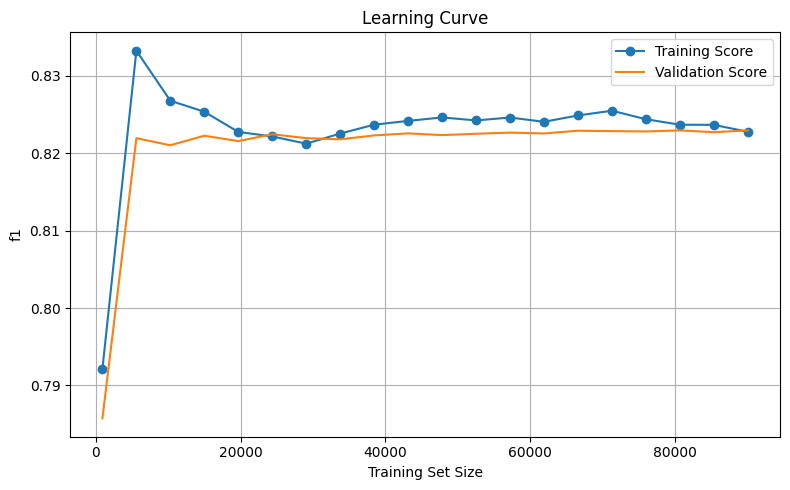

In [22]:

# Generate a learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    lr_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.01, 1.0, 20, dtype=float),
    n_jobs=-1
)

# Calculate mean and std
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Training Score', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation Score', )
plt.xlabel('Training Set Size')
plt.ylabel('f1')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

13


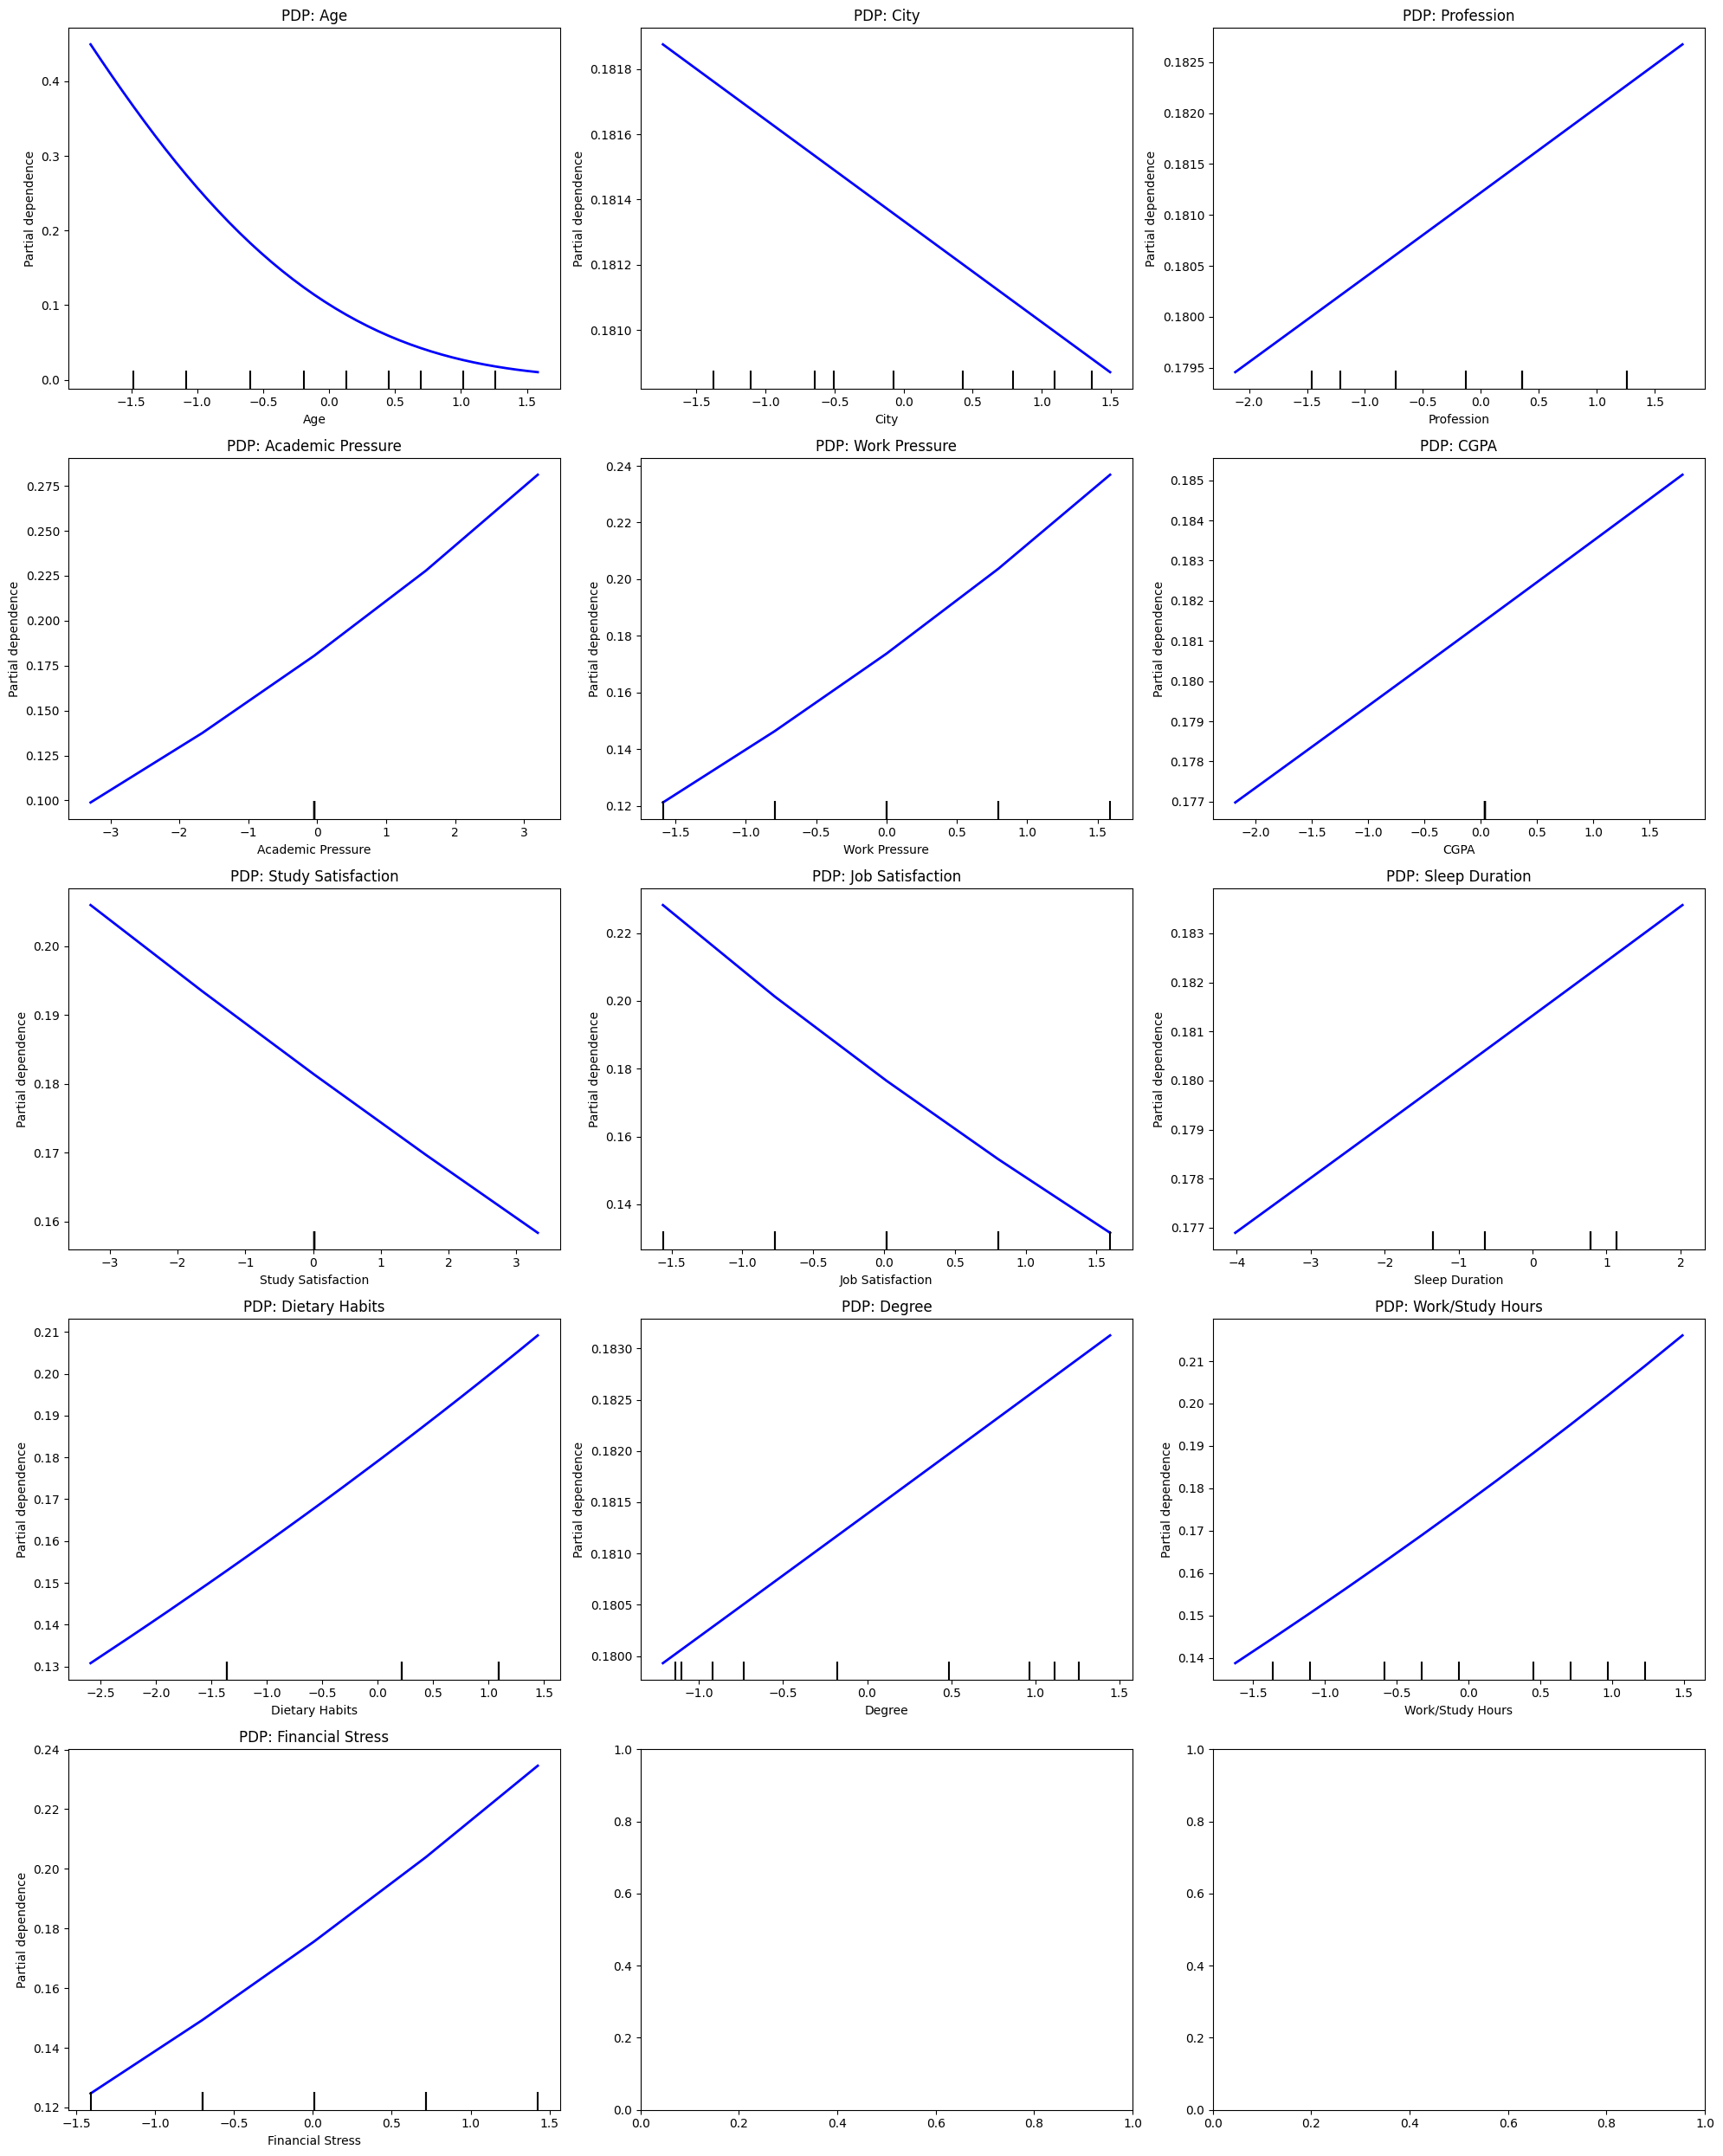

In [ ]:
features = ['Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Work/Study Hours', 'Financial Stress']

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
import numpy as np

# Your selected features
features = ['Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 
            'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 
            'Dietary Habits', 'Degree', 'Work/Study Hours', 'Financial Stress']

from sklearn.inspection import PartialDependenceDisplay

# Create subplot grid (adjust rows/cols as needed)
n_cols = 3  # 3 plots per row
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))


axes = axes.flatten()

for i, feature in enumerate(features):
    try:
        PartialDependenceDisplay.from_estimator(
            lr_model,
            X_train_scaled,
            features=[feature],
            feature_names=X_train.columns.tolist(),
            ax=axes[i],
            kind="average",
            line_kw={'color': 'blue', 'linewidth': 2}
        )
        axes[i].set_title(f"PDP: {feature}", fontsize=12)
        # axes[i].grid(True, alpha=0.3)
    except:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],              # Type of regularization
    'solver': ['liblinear', 'saga'],      # solvers supporting l1 and l2
    'class_weight': [None, 'balanced']    # Try both
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(X_train_scaled, y_train)

# Best model
best_lr_model = grid_search.best_estimator_

# Predict
y_pred = best_lr_model.predict(X_test_scaled)
y_pred_proba = best_lr_model.predict_proba(X_test_scaled)[:, 1]

# After fitting grid_search
print("\nBest Parameters Found:")
print(grid_search.best_params_)


Data loaded successfully!
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters Found:
{'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


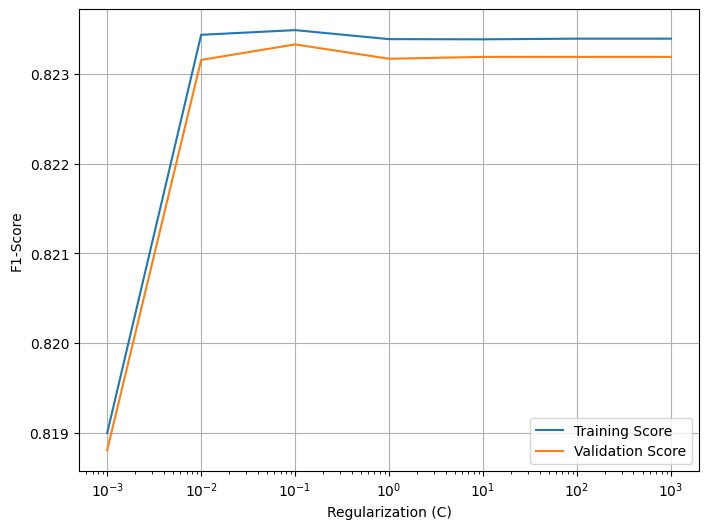

In [8]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores, val_scores = validation_curve(
    estimator=LogisticRegression(penalty='l2', solver='liblinear'),
    X=X_train_scaled,
    y=y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="f1"
)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training Score")
plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation Score")
plt.xscale("log")
plt.xlabel("Regularization (C)")
plt.ylabel("F1-Score")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate synthetic data (or use your actual data)
np.random.seed(42)
X = np.random.rand(1000, 5)  # 1000 samples, 5 features
y = 2*X[:,0] + 3*X[:,1] - X[:,2] + np.random.normal(0, 0.5, 1000)

# Hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Parameters
n_models = 100  # Number of bootstrap models
test_size = 0.2  # Size of bootstrap samples

# Storage
predictions = np.zeros((n_models, len(X_test)))

# Train multiple models on bootstrap samples
for i in range(n_models):
    # Create bootstrap sample
    idx = np.random.choice(len(X_train), size=int(len(X_train)*(1-test_size)), replace=True)
    X_boot = X_train[idx]
    y_boot = y_train[idx]
    
    # Train and predict
    model = LinearRegression()
    model.fit(X_boot, y_boot)
    predictions[i] = model.predict(X_test)

# Calculate components
mean_predictions = np.mean(predictions, axis=0)
bias_squared = np.mean((mean_predictions - y_test)**2)
variance = np.mean(np.var(predictions, axis=0))
noise = np.var(y_test)  # Irreducible error
mse = np.mean((predictions - y_test)**2)

print(f"MSE: {mse:.8f}")
print(f"Bias²: {bias_squared:.8f}")
print(f"Variance: {variance:.8f}")
print(f"Noise: {noise:.8f}")
print(f"Bias² + Variance: {bias_squared + variance:.8f}")
print(f"Estimated Eout (MSE): {mse:.8f}")

MSE: 0.23049104
Bias²: 0.22816216
Variance: 0.00232888
Noise: 1.51089558
Bias² + Variance: 0.23049104
Estimated Eout (MSE): 0.23049104


# Adaboost

Data loaded successfully!

AdaBoost Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.82      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140



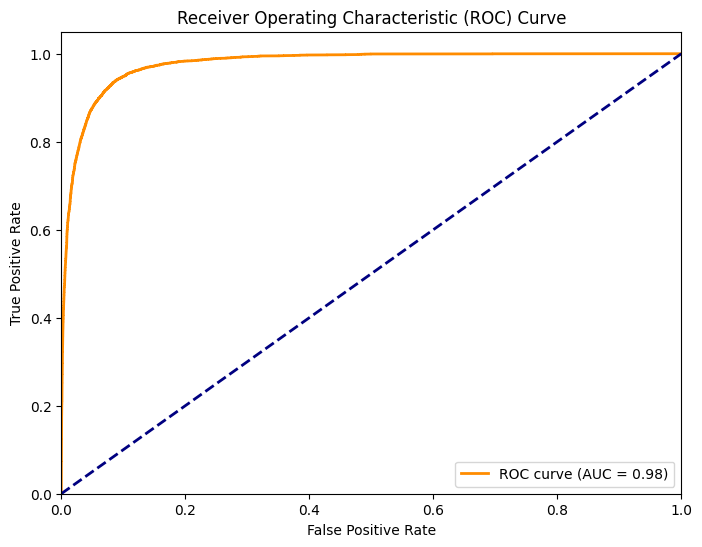

e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


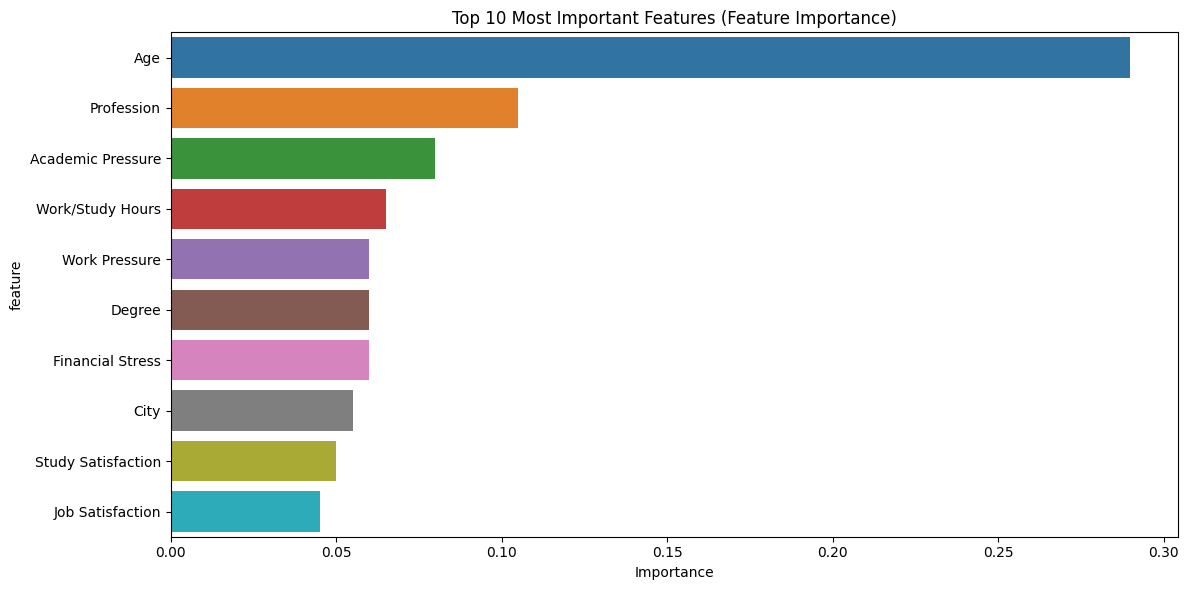


Top 10 Features by Importance:
           feature  importance
               Age       0.290
        Profession       0.105
 Academic Pressure       0.080
  Work/Study Hours       0.065
     Work Pressure       0.060
            Degree       0.060
  Financial Stress       0.060
              City       0.055
Study Satisfaction       0.050
  Job Satisfaction       0.045


In [14]:
#Best Parameters Found:
# {'learning_rate': 1.0, 'n_estimators': 200}


from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the AdaBoost model
ab_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)
ab_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ab_model.predict(X_test_scaled)
y_pred_proba = ab_model.predict_proba(X_test_scaled)[:, 1]

# Print model performance
print("\nAdaBoost Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': ab_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Feature Importance)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10).to_string(index=False))


Data loaded successfully!
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters Found:
{'learning_rate': 1.0, 'n_estimators': 200}

Best ROC AUC Score:
0.9741452893451032

AdaBoost Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.82      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140



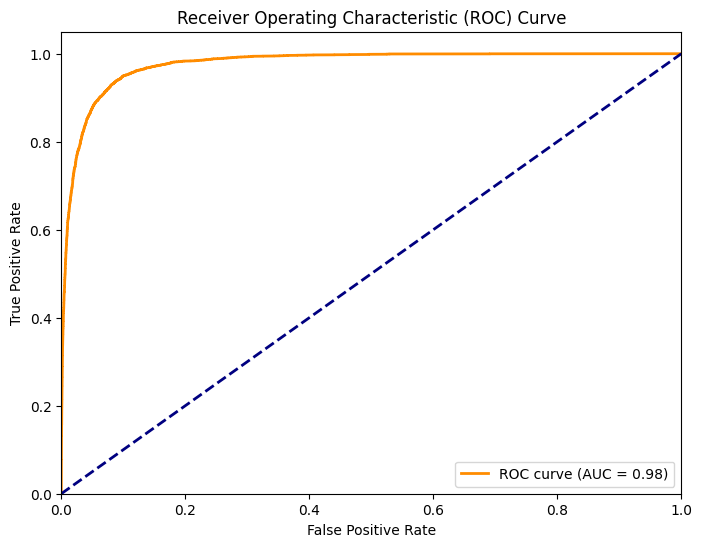

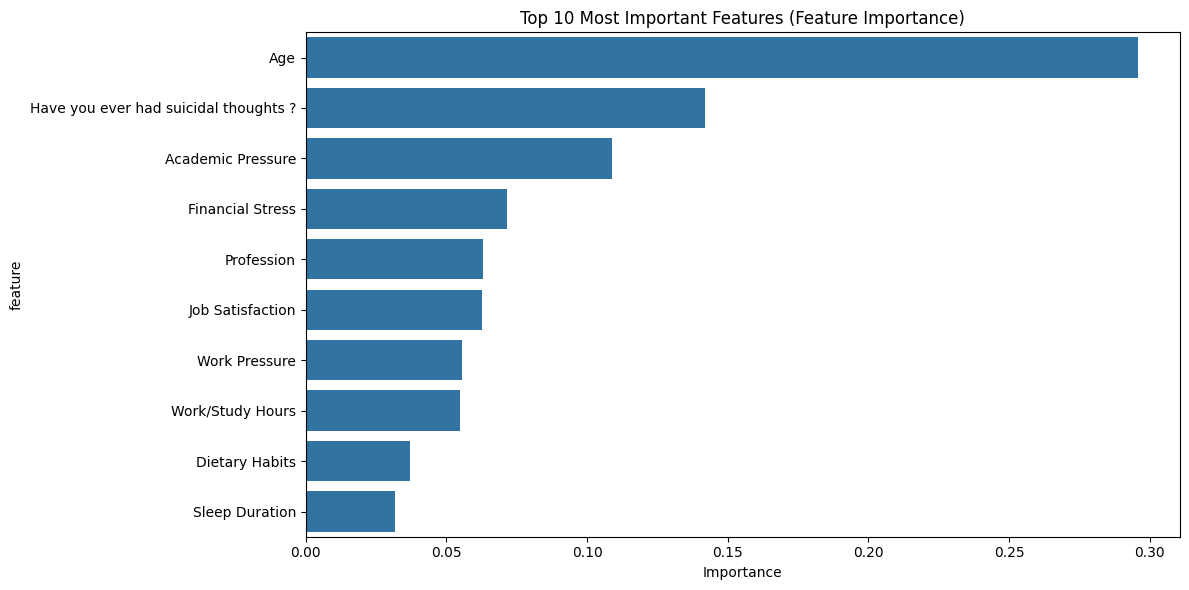


Top 10 Features by Importance:
                              feature  importance
                                  Age    0.295918
Have you ever had suicidal thoughts ?    0.141957
                    Academic Pressure    0.108861
                     Financial Stress    0.071532
                           Profession    0.063041
                     Job Satisfaction    0.062672
                        Work Pressure    0.055522
                     Work/Study Hours    0.054831
                       Dietary Habits    0.037175
                       Sleep Duration    0.031692


In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Grid Search for AdaBoost Hyperparameter Tuning ---
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Set up GridSearchCV with AdaBoostClassifier
grid_search = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Print best hyperparameters and best ROC AUC score
print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("\nBest ROC AUC Score:")
print(grid_search.best_score_)

# Use the best estimator from GridSearchCV for further evaluation
best_ab_model = grid_search.best_estimator_

# --- Evaluation using the Best AdaBoost Model ---
# Make predictions
y_pred = best_ab_model.predict(X_test_scaled)
y_pred_proba = best_ab_model.predict_proba(X_test_scaled)[:, 1]

# Print model performance
print("\nAdaBoost Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_ab_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Feature Importance)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print top 10 features by importance
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10).to_string(index=False))


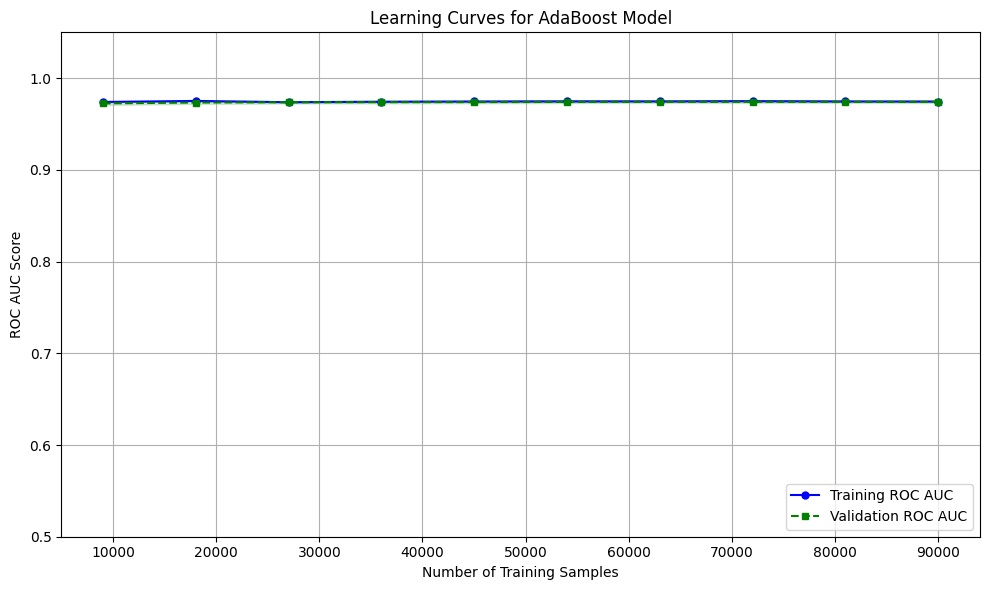

In [7]:
from sklearn.model_selection import learning_curve

# Set up the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_ab_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42 
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', 
         markersize=5, label='Training ROC AUC')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', 
         marker='s', markersize=5, label='Validation ROC AUC')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('ROC AUC Score')
plt.legend(loc='lower right')
plt.title('Learning Curves for AdaBoost Model')
plt.ylim([0.5, 1.05])  # Adjust based on your expected ROC AUC range
plt.tight_layout()
plt.show()

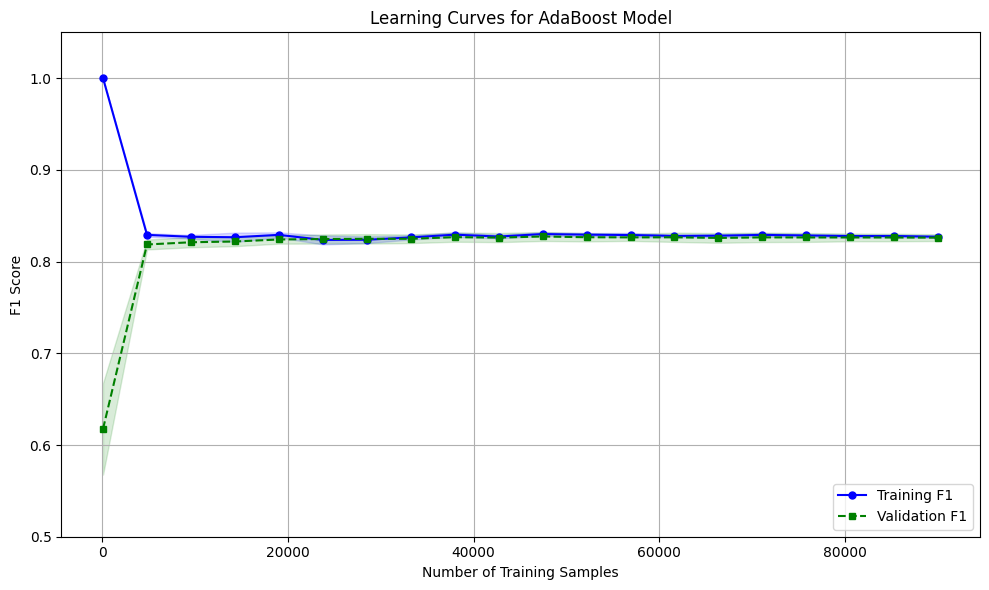

In [9]:
from sklearn.model_selection import learning_curve

# Set up the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_ab_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.001, 1.0, 20),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', 
         markersize=5, label='Training F1 ')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', 
         marker='s', markersize=5, label='Validation F1')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.title('Learning Curves for AdaBoost Model')
plt.ylim([0.5, 1.05])  # Adjust based on your expected ROC AUC range
plt.tight_layout()
plt.show()

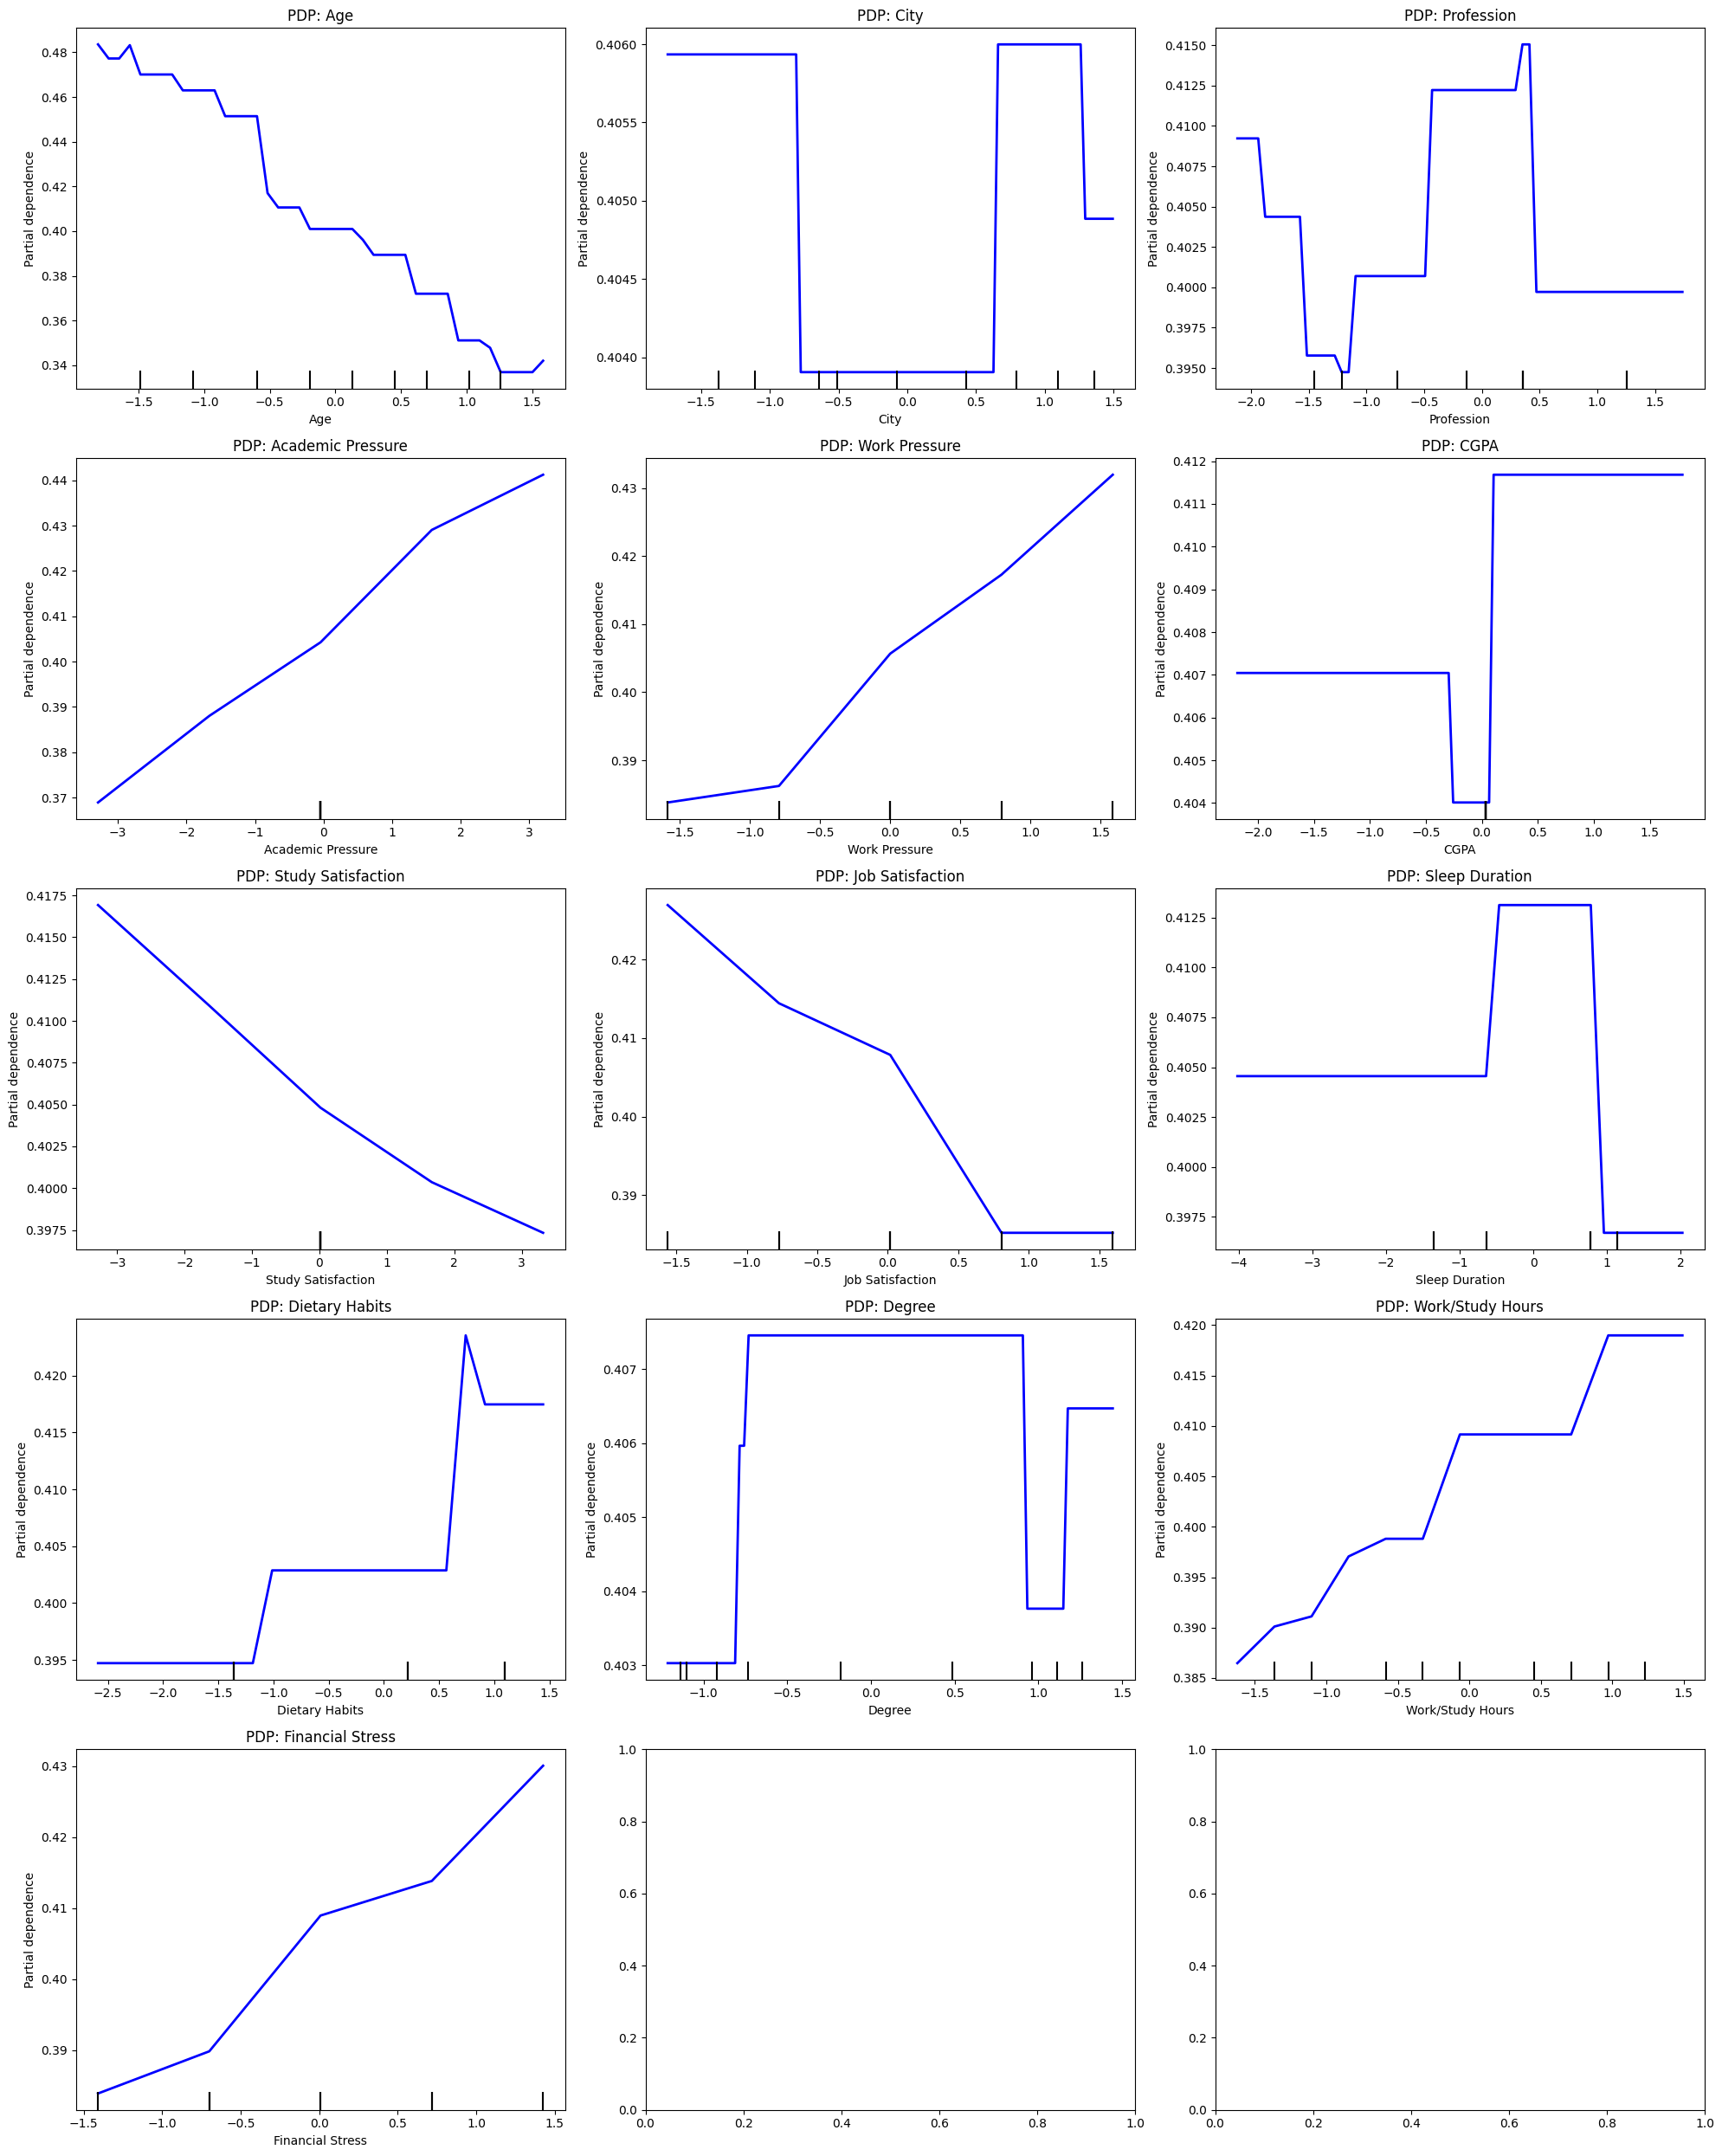

In [10]:
features = ['Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Work/Study Hours', 'Financial Stress']

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
import numpy as np

# Your selected features
features = ['Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 
            'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 
            'Dietary Habits', 'Degree', 'Work/Study Hours', 'Financial Stress']

from sklearn.inspection import PartialDependenceDisplay

# Create subplot grid (adjust rows/cols as needed)
n_cols = 3  # 3 plots per row
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))


axes = axes.flatten()

for i, feature in enumerate(features):
    try:
        PartialDependenceDisplay.from_estimator(
            best_ab_model,
            X_train_scaled,
            features=[feature],
            feature_names=X_train.columns.tolist(),
            ax=axes[i],
            kind="average",
            line_kw={'color': 'blue', 'linewidth': 2}
        )
        axes[i].set_title(f"PDP: {feature}", fontsize=12)
        # axes[i].grid(True, alpha=0.3)
    except:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

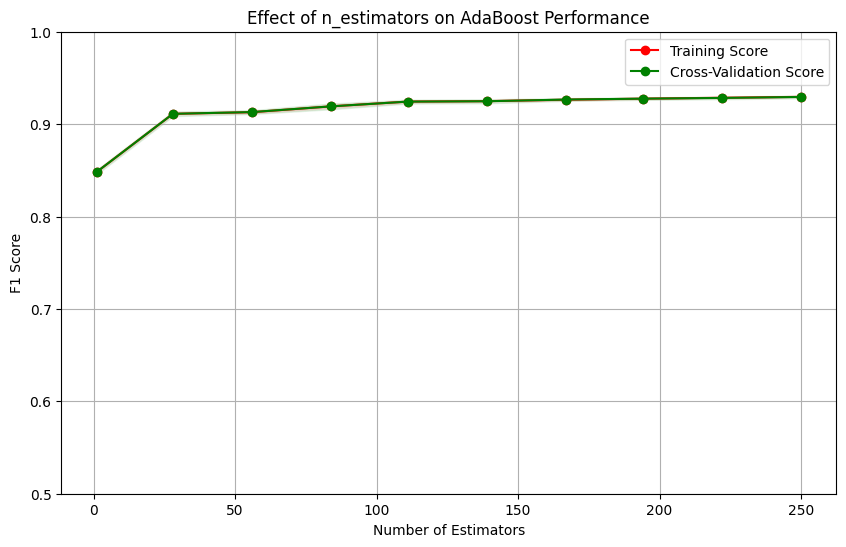

Optimal number of estimators: 250
Best F1 score: 0.929 ± 0.002


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score, make_scorer

# Define the range of n_estimators to test
param_range = np.linspace(1, 250, 10, dtype=int)

# Calculate validation curve for n_estimators
train_scores, test_scores = validation_curve(
    AdaBoostClassifier(learning_rate=0.1, random_state=42),
    X_train_scaled,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.title("Effect of n_estimators on AdaBoost Performance")
plt.xlabel("Number of Estimators")
plt.ylabel("F1 Score")
plt.ylim(0.5, 1.0)
plt.grid()

plt.plot(param_range, train_mean, 'o-', color="r", label="Training Score")
plt.plot(param_range, test_mean, 'o-', color="g", label="Cross-Validation Score")

# Plot standard deviation bands
plt.fill_between(
    param_range,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    param_range,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
    color="g"
)

plt.legend(loc="best")
plt.show()

# Print optimal number of estimators
optimal_idx = np.argmax(test_mean)
optimal_estimators = param_range[optimal_idx]
print(f"Optimal number of estimators: {optimal_estimators}")
print(f"Best F1 score: {test_mean[optimal_idx]:.3f} ± {test_std[optimal_idx]:.3f}")

Data loaded successfully!
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best Parameters: {'learning_rate': 1.0, 'n_estimators': 1000}
Best F1 Score: 0.828872723373611


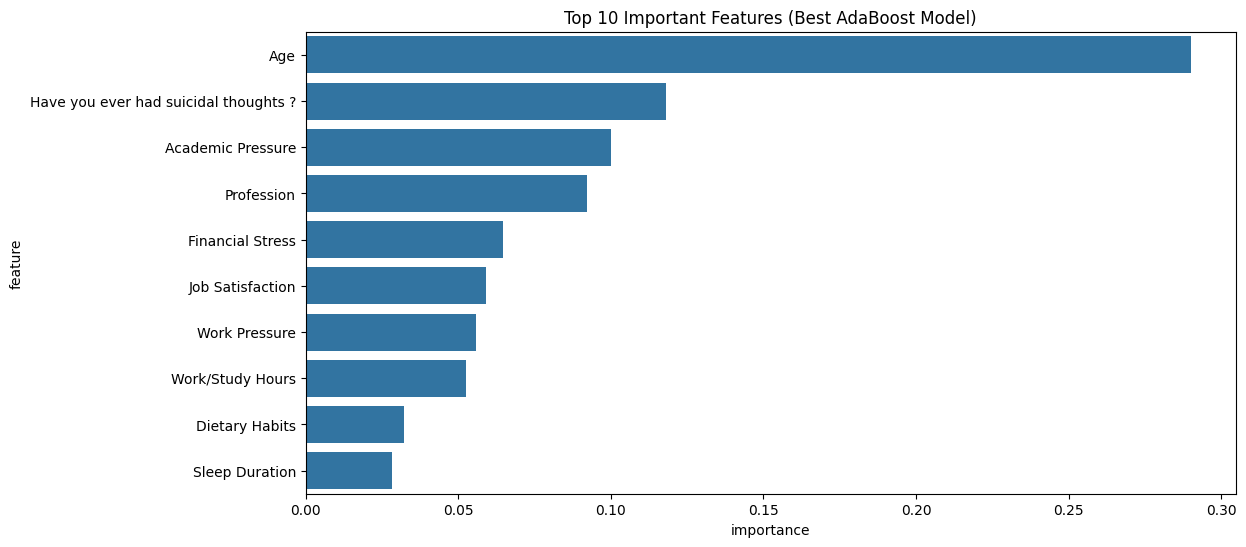

In [24]:

# Load your preprocessed data (replace with your actual data)
X_train, X_test, y_train, y_test = preprocess_data()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100,200, 500,1000],       # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0],    # Shrinkage factor
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                          # 5-fold cross-validation
    scoring=make_scorer(f1_score),  # Use F1 for imbalanced data
    n_jobs=-1,                     # Use all CPU cores
    verbose=2                      # Print progress
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# --- Results Analysis ---
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


# --- Best Model Evaluation ---
best_model = grid_search.best_estimator_

# Feature Importance Plot
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title("Top 10 Important Features (Best AdaBoost Model)")
plt.show()

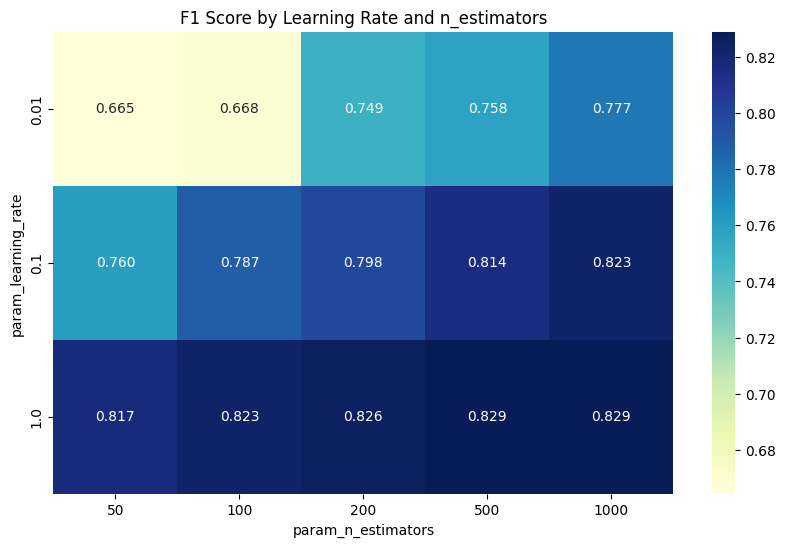

In [27]:
# 1. Heatmap of n_estimators vs learning_rate
pivot_table = results.pivot_table(
    index='param_learning_rate', 
    columns='param_n_estimators', 
    values='mean_test_score'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("F1 Score by Learning Rate and n_estimators")
plt.show()

# XGboost

In [6]:

X_train, X_test, y_train, y_test = preprocess_data()

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data()

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    n_estimators=100,            # number of trees
    max_depth=3,                 # maximum depth of each tree
    learning_rate=0.1,           # learning rate
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Data loaded successfully!
Data loaded successfully!
Accuracy: 0.9378

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.81      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140



Top 10 Feature Importances:
                                  Feature  Importance
1                                     Age    0.399270
13  Have you ever had suicidal thoughts ?    0.197126
5                       Academic Pressure    0.072134
15                       Financial Stress    0.067667
3         Working Professional or Student    0.060518
6                           Work Pressure    0.039406
14                       Work/Study Hours    0.038806
9                        Job Satisfaction    0.035614
11                         Dietary Habits    0.028448
10                         Sleep Duration    0.018597


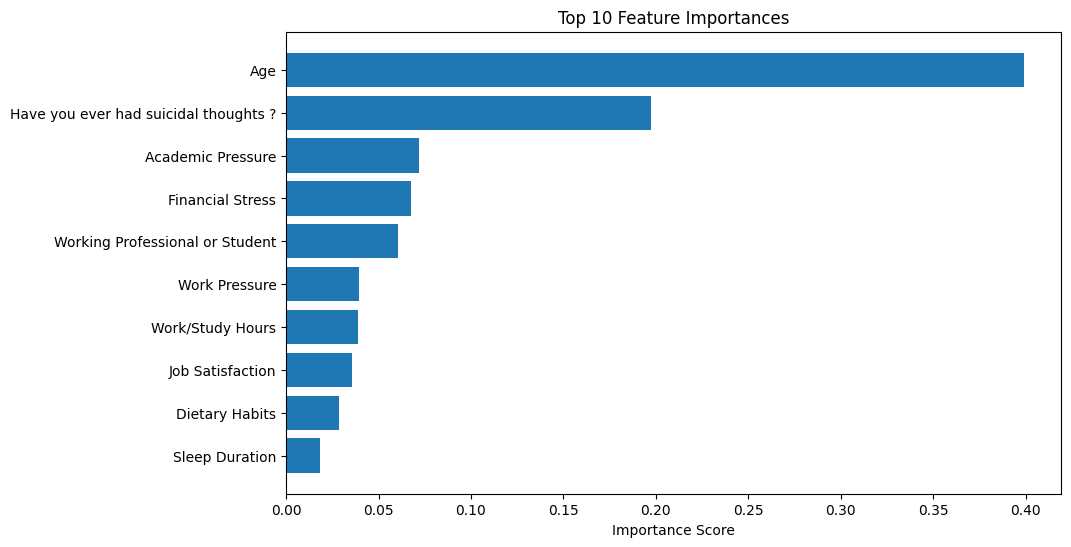

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming you've already trained your model (xgb_model) and have X_train
feature_importance = xgb_model.feature_importances_

# Create a DataFrame to store feature importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort features by importance (descending order)
importance_df = importance_df.sort_values('Importance', ascending=False)

# Get top 10 features
top_10_features = importance_df.head(10)

# Display the top 10 features
print("Top 10 Feature Importances:")
print(top_10_features)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.gca().invert_yaxis()  # Most important at top
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances')
plt.show()

In [22]:
first_5_features = importance_df.head(5)
# print(first_5_features['Feature'].to_list())
X_train, X_test, y_train, y_test = select_specific_features_data(list(set(first_5_features['Feature'].to_list()) - set(['Academic Pressure'])))


# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    n_estimators=100,            # number of trees
    max_depth=3,                 # maximum depth of each tree
    learning_rate=0.1,           # learning rate
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Data loaded successfully!
Accuracy: 0.9182

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     22986
           1       0.78      0.77      0.77      5154

    accuracy                           0.92     28140
   macro avg       0.86      0.86      0.86     28140
weighted avg       0.92      0.92      0.92     28140

